# Build TF-Agents Bandit model and execute locally

In [2]:
# pip install --user google-cloud-aiplatform
# pip install --user google-cloud-storage
# pip install --user numpy
# pip install --user cloudml-hypertune
# pip install --user tensorflow==2.12.0 tensorflow-serving-api==2.11.0
# pip install --user tf-agents==0.16.0
# pip install --user tensorboard-data-server==0.7.1
# pip install --user tensorboard-plugin-profile==2.13.0
# pip install --user tensorflow-io==0.29.0
# pip install --user --upgrade pillow

In [3]:
! python3 -c "import google.cloud.aiplatform; print('aiplatform SDK version: {}'.format(google.cloud.aiplatform.__version__))"

aiplatform SDK version: 1.26.0


In [4]:
!pwd

/home/jupyter/jt-github/tf_vertex_agents


### set vars

In [5]:
PREFIX = 'tabv1'

In [6]:
# creds, PROJECT_ID = google.auth.default()
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

PROJECT_NUM              = !gcloud projects describe $PROJECT_ID --format="value(projectNumber)"
PROJECT_NUM              = PROJECT_NUM[0]

VERTEX_SA                = f'{PROJECT_NUM}-compute@developer.gserviceaccount.com'

VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

# locations / regions for cloud resources
LOCATION                 = 'us-central1'        
REGION                   = LOCATION
BQ_LOCATION              = 'US'

print(f"PROJECT_ID       = {PROJECT_ID}")
print(f"PROJECT_NUM      = {PROJECT_NUM}")
print(f"VPC_NETWORK_NAME = {VPC_NETWORK_NAME}")
print(f"LOCATION         = {LOCATION}")
print(f"REGION           = {REGION}")
print(f"BQ_LOCATION      = {BQ_LOCATION}")

PROJECT_ID       = hybrid-vertex
PROJECT_NUM      = 934903580331
VPC_NETWORK_NAME = genai-haystack-vpc
LOCATION         = us-central1
REGION           = us-central1
BQ_LOCATION      = US


In [7]:
# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

# Location of the MovieLens 100K dataset's "u.data" file.
DATA_PATH                = f"{BUCKET_URI}/artifacts/u.data"

VPC_NETWORK_FULL         = f"projects/{PROJECT_NUM}/global/networks/{VPC_NETWORK_NAME}"

MY_BQ_DATASET            = BUCKET_NAME.lower().replace("-","_")

print(f"BUCKET_NAME       : {BUCKET_NAME}")
print(f"BUCKET_URI        : {BUCKET_URI}")
print(f"DATA_PATH         : {DATA_PATH}")
print(f"VPC_NETWORK_FULL  : {VPC_NETWORK_FULL}")
print(f"MY_BQ_DATASET     : {MY_BQ_DATASET}")

BUCKET_NAME       : tabv1-hybrid-vertex-bucket
BUCKET_URI        : gs://tabv1-hybrid-vertex-bucket
DATA_PATH         : gs://tabv1-hybrid-vertex-bucket/artifacts/u.data
VPC_NETWORK_FULL  : projects/934903580331/global/networks/genai-haystack-vpc
MY_BQ_DATASET     : tabv1_hybrid_vertex_bucket


#### create GCS bucket

In [9]:
# create bucket
! gsutil mb -l $REGION $BUCKET_URI

Creating gs://tabv1-hybrid-vertex-bucket/...


In [10]:
! gsutil ls -al $BUCKET_URI

### imports

In [12]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [30]:
import functools
import json
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time

import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
from tf_agents.agents import TFAgent
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.bandits.environments import (environment_utilities,
                                            movielens_py_environment)
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import TFEnvironment, tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.metrics.tf_metric import TFStepMetric
from tf_agents.policies import policy_saver

if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

### detect GPUs & reset devices

In [16]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [17]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [18]:
import gc
gc.collect()

14

### Initialize Google Cloud SDK Clients

In [20]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# # bigquery client
# bqclient = bigquery.Client(
#     project=PROJECT_ID,
#     # location=LOCATION
# )

## Data prep

### copy sample data to $DATA_PATH

In [21]:
SAMPLE_DATA_URI = "gs://cloud-samples-data/vertex-ai/community-content/tf_agents_bandits_movie_recommendation_with_kfp_and_vertex_sdk/u.data"

! gsutil cp $SAMPLE_DATA_URI $DATA_PATH

Copying gs://cloud-samples-data/vertex-ai/community-content/tf_agents_bandits_movie_recommendation_with_kfp_and_vertex_sdk/u.data [Content-Type=application/octet-stream]...
/ [1 files][  1.9 MiB/  1.9 MiB]                                                
Operation completed over 1 objects/1.9 MiB.                                      


In [22]:
! gsutil ls -al $DATA_PATH

   1979173  2023-07-04T12:47:39Z  gs://tabv1-hybrid-vertex-bucket/artifacts/u.data#1688474859744626  metageneration=1
TOTAL: 1 objects, 1979173 bytes (1.89 MiB)


## Define & Train RL modules

### set hyperparameters

In [24]:
# Set hyperparameters.
BATCH_SIZE       = 8      # Training and prediction batch size.
TRAINING_LOOPS   = 5      # Number of training iterations.
STEPS_PER_LOOP   = 2      # Number of driver steps per training iteration.

# Set MovieLens simulation environment parameters.
RANK_K           = 20     # Rank for matrix factorization in the MovieLens environment; also the observation dimension.
NUM_ACTIONS      = 20     # Number of actions (movie items) to choose from.
PER_ARM          = False  # Use the non-per-arm version of the MovieLens environment.

# Set agent parameters.
TIKHONOV_WEIGHT  = 0.001   # LinUCB Tikhonov regularization weight.
AGENT_ALPHA      = 10.0    # LinUCB exploration parameter that multiplies the confidence intervals.

print(f"BATCH_SIZE       : {BATCH_SIZE}")
print(f"TRAINING_LOOPS   : {TRAINING_LOOPS}")
print(f"STEPS_PER_LOOP   : {STEPS_PER_LOOP}")
print(f"RANK_K           : {RANK_K}")
print(f"NUM_ACTIONS      : {NUM_ACTIONS}")
print(f"PER_ARM          : {PER_ARM}")
print(f"TIKHONOV_WEIGHT  : {TIKHONOV_WEIGHT}")
print(f"AGENT_ALPHA      : {AGENT_ALPHA}")

BATCH_SIZE       : 8
TRAINING_LOOPS   : 5
STEPS_PER_LOOP   : 2
RANK_K           : 20
NUM_ACTIONS      : 20
PER_ARM          : False
TIKHONOV_WEIGHT  : 0.001
AGENT_ALPHA      : 10.0


### Define RL environment

One can define a bandit environment by subclassing `BanditTFEnvironment`, or, similarly to RL environments, one can define a `BanditPyEnvironment` and wrap it with `TFPyEnvironment`

In [25]:
env = movielens_py_environment.MovieLensPyEnvironment(
    data_dir = DATA_PATH
    , rank_k = RANK_K
    , batch_size = BATCH_SIZE
    , num_movies = NUM_ACTIONS
    , csv_delimiter = "\t"
)

environment = tf_py_environment.TFPyEnvironment(env)

### Define RL agent/algorithm

In [26]:
agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec = environment.time_step_spec()
    , action_spec = environment.action_spec()
    , tikhonov_weight = TIKHONOV_WEIGHT
    , alpha = AGENT_ALPHA
    , dtype = tf.float32
    , accepts_per_arm_features = PER_ARM
)

print("TimeStep Spec (for each batch):\n", agent.time_step_spec, "\n")
print("Action Spec (for each batch)  :\n", agent.action_spec, "\n")
print("Reward Spec (for each batch)  :\n", environment.reward_spec(), "\n")

TimeStep Spec (for each batch):
 TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': TensorSpec(shape=(20,), dtype=tf.float64, name='observation'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}) 

Action Spec (for each batch)  :
 BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(19, dtype=int32)) 

Reward Spec (for each batch)  :
 TensorSpec(shape=(), dtype=tf.float32, name='reward') 



### Define RL metric

Bandits' most important metric is **regret**, calculated as the difference between the reward collected by the agent and the expected reward of an oracle policy that has access to the reward functions of the environment. The [RegretMetric](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/metrics/tf_metrics.py) thus needs a `baseline_reward_fn` function that calculates the best achievable expected reward given an observation. For our example, we need to take the maximum of the no-noise equivalents of the reward functions that we already defined for the environment.

In [27]:
optimal_reward_fn = functools.partial(
    environment_utilities.compute_optimal_reward_with_movielens_environment
    , environment=environment
)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)

metrics = [regret_metric]

## Train (locally)

A **policy** in a bandit problem works the same way as in an RL problem: it provides an action (or a distribution of actions), given an observation as input.
* For more details, see the [TF-Agents Policy tutorial](https://github.com/tensorflow/agents/blob/master/docs/tutorials/3_policies_tutorial.ipynb).
* As with environments, there are two ways to construct a policy: One can create a `PyPolicy` and wrap it with `TFPyPolicy`, or directly create a `TFPolicy`

**Replay buffers**
* Reinforcement learning algorithms use `replay buffers` to store trajectories of experience when executing a policy in an environment. * During training, replay buffers are queried for a subset of the trajectories (either a sequential subset or a sample) to "replay" the agent's experience.

### Define the training logic (on-policy training)

> The following function is the same as [trainer.train](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples/v2/trainer.py#L130), but it keeps track of intermediate metric values and saves different artifacts to different locations. You can also directly invoke [trainer.train](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples/v2/trainer.py#L130) which also trains the policy.

In [28]:
def train(
    root_dir: str,
    agent: TFAgent,
    environment: TFEnvironment,
    training_loops: int,
    steps_per_loop: int,
    additional_metrics: Optional[List[TFStepMetric]] = None,
    training_data_spec_transformation_fn: Optional[Callable[[T], T]] = None,
) -> Dict[str, List[float]]:
    """Performs `training_loops` iterations of training on the agent's policy.

    Uses the `environment` as the problem formulation and source of immediate
    feedback and the agent's algorithm, to perform `training-loops` iterations
    of on-policy training on the policy.
    If one or more baseline_reward_fns are provided, the regret is computed
    against each one of them. Here is example baseline_reward_fn:
    def baseline_reward_fn(observation, per_action_reward_fns):
        rewards = ... # compute reward for each arm
        optimal_action_reward = ... # take the maximum reward
        return optimal_action_reward

    Args:
        root_dir: Path to the directory where training artifacts are written.
        agent: An instance of `TFAgent`.
        environment: An instance of `TFEnvironment`.
        training_loops: An integer indicating how many training loops should be run.
        steps_per_loop: An integer indicating how many driver steps should be
           executed and presented to the trainer during each training loop.
        additional_metrics: Optional; list of metric objects to log, in addition to
          default metrics `NumberOfEpisodes`, `AverageReturnMetric`, and
          `AverageEpisodeLengthMetric`.
        training_data_spec_transformation_fn: Optional; function that transforms
          the data items before they get to the replay buffer.

    Returns:
        A dict mapping metric names (eg. "AverageReturnMetric") to a list of
        intermediate metric values over `training_loops` iterations of training.
    """
    
    # ====================================================
    # get data spec
    # ====================================================
    if training_data_spec_transformation_fn is None:
        data_spec = agent.policy.trajectory_spec
    else:
        data_spec = training_data_spec_transformation_fn(
            agent.policy.trajectory_spec
        )
        
    # ====================================================
    # define replay buffer
    # ====================================================
    replay_buffer = trainer._get_replay_buffer(
        data_spec
        , environment.batch_size
        ,steps_per_loop
        , 1
    )

    # ====================================================
    # metrics
    # ====================================================
    
    # `step_metric` records the number of individual rounds of bandit interaction;
    # that is, (number of trajectories) * batch_size.
    step_metric = tf_metrics.EnvironmentSteps()
    
    metrics = [
        tf_metrics.NumberOfEpisodes(),
        tf_metrics.AverageEpisodeLengthMetric(batch_size=environment.batch_size)
    ]
    if additional_metrics:
        metrics += additional_metrics

    if isinstance(environment.reward_spec(), dict):
        metrics += [
            tf_metrics.AverageReturnMultiMetric(
                reward_spec=environment.reward_spec(),
                batch_size=environment.batch_size)
        ]
    else:
        metrics += [
            tf_metrics.AverageReturnMetric(batch_size=environment.batch_size)
        ]

    # Store intermediate metric results, indexed by metric names.
    metric_results = defaultdict(list)
    print(f"metric_results: {metric_results}")
    
    # ====================================================
    # Driver
    # ====================================================
    if training_data_spec_transformation_fn is not None:
        def add_batch_fn(data): return replay_buffer.add_batch(training_data_spec_transformation_fn(data)) 
        
    else:
        add_batch_fn = replay_buffer.add_batch

    observers = [add_batch_fn, step_metric] + metrics

    driver = dynamic_step_driver.DynamicStepDriver(
        env = environment
        , policy = agent.collect_policy
        , num_steps = steps_per_loop * environment.batch_size
        , observers = observers
    )

    # ====================================================
    # training_loop
    # ====================================================
    training_loop = trainer._get_training_loop(
        driver=driver
        , replay_buffer=replay_buffer
        , agent=agent
        , steps=steps_per_loop
        , async_steps_per_loop=1
    )
    saver = policy_saver.PolicySaver(agent.policy)

    # for _ in range(training_loops):
    for train_step in range(training_loops):
        training_loop(    # JT TODO
            train_step=train_step
            , metrics=metrics
        )
        metric_utils.log_metrics(metrics)
        for metric in metrics:
            metric.tf_summaries(train_step=step_metric.result())
            metric_results[type(metric).__name__].append(metric.result().numpy())
    saver.save(root_dir)
    
    return metric_results

### set Vertex Exeperiment

In [32]:
EXPERIMENT_NAME   = f'build-local-test'

invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

LOG_DIR           = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/tb-logs"
ROOT_DIR          = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : build-local-test
RUN_NAME          : run-20230704-125143
LOG_DIR           : gs://tabv1-hybrid-vertex-bucket/build-local-test/run-20230704-125143/tb-logs
ROOT_DIR          : gs://tabv1-hybrid-vertex-bucket/build-local-test/run-20230704-125143/root
ARTIFACTS_DIR     : gs://tabv1-hybrid-vertex-bucket/build-local-test/run-20230704-125143/artifacts


### Managed Tensorboard

In [33]:
# # create new TB instance
TENSORBOARD_DISPLAY_NAME=f"{EXPERIMENT_NAME}-{RUN_NAME}"
tensorboard = aiplatform.Tensorboard.create(display_name=TENSORBOARD_DISPLAY_NAME)
TB_RESOURCE_NAME = tensorboard.resource_name

# use existing TB instance
# TB_RESOURCE_NAME = 'projects/934903580331/locations/us-central1/tensorboards/472921941339013120'

print(f"TB_RESOURCE_NAME: {TB_RESOURCE_NAME}")

TB_RESOURCE_NAME: projects/934903580331/locations/us-central1/tensorboards/3607444874174922752


### train RL agent

In [34]:
#start the timer and training
start_time = time.time()

tf.profiler.experimental.start(LOG_DIR)
metric_results = train(
    root_dir=ROOT_DIR,
    agent=agent,
    environment=environment,
    training_loops=TRAINING_LOOPS,
    steps_per_loop=STEPS_PER_LOOP,
    additional_metrics=metrics
)
tf.profiler.experimental.stop()

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)

/home/jupyter/.local/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


In [35]:
metric_results

defaultdict(list,
            {'NumberOfEpisodes': [16, 32, 48, 64, 80],
             'AverageEpisodeLengthMetric': [1.0, 1.0, 1.0, 1.0, 1.0],
             'RegretMetric': [2.875, 4.5, 4.5, 3.375, 4.75],
             'AverageReturnMetric': [1.8,
              0.3,
              -8.2687896e-16,
              0.8,
              -3.0805627e-15]})

### log Vertex Experiment run

In [38]:
aiplatform.start_run(RUN_NAME, tensorboard=TB_RESOURCE_NAME)

aiplatform.log_params(
    {
        "runtime": runtime_mins,
        "batch_size": BATCH_SIZE, 
        "training_loops": TRAINING_LOOPS,
        "steps_pre_loop": STEPS_PER_LOOP,
        "rank_k": RANK_K,
        "num_actions": NUM_ACTIONS,
        "per_arm": PER_ARM,
        "tikhonov_weight": TIKHONOV_WEIGHT,
        "agent_alpha": AGENT_ALPHA,
    }
)

# gather the metrics for the last epoch to be saved in metrics
aiplatform.log_metrics(
    {
        "AverageReturnMetric" : metric_results["AverageReturnMetric"][-1]
        , "FinalRegretMetric" : metric_results["RegretMetric"][-1]
    }
)

aiplatform.end_run()

## Evaluate RL metrics

In [41]:
def plot(metric_results, metric_name):
    plt.plot(metric_results[metric_name])
    plt.ylabel(metric_name)
    plt.xlabel("Step")
    plt.title("{} versus Step".format(metric_name))

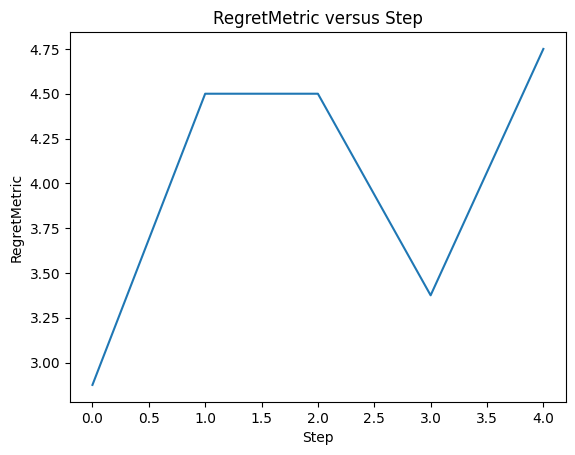

In [42]:
plot(metric_results, "RegretMetric")

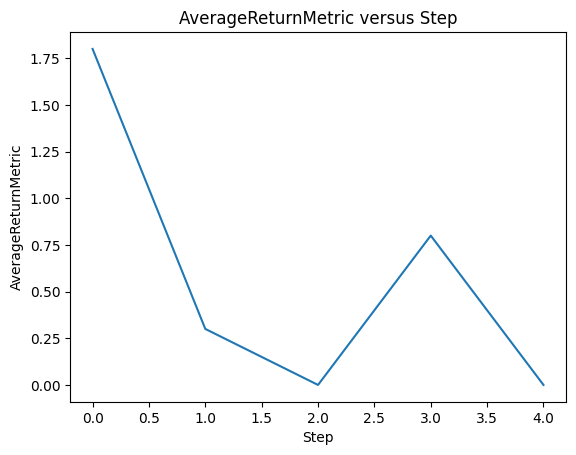

In [43]:
plot(metric_results, "AverageReturnMetric")

### Profiler

In [44]:
%load_ext tensorboard
# %reload_ext tensorboard

In [45]:
%tensorboard --logdir=$LOG_DIR

### load trained policy

In [46]:
loaded_policy = tf.saved_model.load(ROOT_DIR)
loaded_policy

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f7ae46e97e0>